# PyCoMo Basics #
PyCoMo is a **Py**thon **Co**mmunity metabolic **Mo**delling package. In this tutorial, the core features will be presented.

The expected runtime for this notebook is approximately 10-30 minutes.

## Setting up PyCoMo ##
Clone the package from github. Next, we are going to import all the packages we need in this tutorial.

In [1]:
from pathlib import Path
import sys
import cobra
import os

### Importing PyCoMo ###

In [2]:
import pycomo
pycomo.configure_logger(level="info")

2025-11-24 16:01:37,435 - PyCoMo - INFO - Logger initialized.


## Creating a Community Model ##
The creation of a community model consists of 3 steps:
1. Loading the member models
2. Preparing the member models for merging
3. Creating a community model

### Loading the member models ###
The community model creation process starts with models of the individual members. Note that the quality of the community model heavily depends on the quality of the member models!

In this tutorial we are using metabolic models from the AGORA collection. The models were retrieved from www.vmh.life, and are stored in the data folder of the repository. The selection of models and the resulting community represents a cystic fibrosis airway community, as done by Henson et al. (www.doi.org/10.1128/mSystems.00026-19)

In [3]:
test_model_dir = "../data/use_case/henson"
named_models = pycomo.load_named_models_from_dir(test_model_dir)

The models and file names were extracted and stored in named_models. Let's check the contents:

In [4]:
named_models

{'Achromobacter_xylosoxidans_NBRC_15126': <Model Achromobacter_xylosoxidans_NBRC_15126 at 0x2ce3c81f310>,
 'Actinomyces_naeslundii_str_Howell_279': <Model Actinomyces_naeslundii_str_Howell_279 at 0x2ce4c486110>,
 'Burkholderia_cepacia_GG4': <Model Burkholderia_cepacia_GG4 at 0x2ce4de34610>,
 'Escherichia_coli_str_K_12_substr_MG1655': <Model Escherichia_coli_str_K_12_substr_MG1655 at 0x2ce4eb14110>,
 'Fusobacterium_nucleatum_subsp_nucleatum_ATCC_25586': <Model Fusobacterium_nucleatum_subsp_nucleatum_ATCC_25586 at 0x2ce50708290>,
 'Gemella_haemolysans_ATCC_10379': <Model Gemella_haemolysans_ATCC_10379 at 0x2ce514e81d0>,
 'Granulicatella_adiacens_ATCC_49175': <Model Granulicatella_adiacens_ATCC_49175 at 0x2ce51ba0f50>,
 'Haemophilus_influenzae_R2846': <Model Haemophilus_influenzae_R2846 at 0x2ce522f0610>,
 'Neisseria_flavescens_SK114': <Model Neisseria_flavescens_SK114 at 0x2ce52b30510>,
 'Porphyromonas_endodontalis_ATCC_35406': <Model Porphyromonas_endodontalis_ATCC_35406 at 0x2ce5344011

### Preparing the models for merging ###
With the models loaded, the next step is preparing them for merging. This is done by creating SingleOrganismModel objects. Using them, the models will be formatted for compliance with the SBML format. Further, an exchange compartment will be generated under the name _medium_.

One of the requirements for a community metabolic model is a common biomass function. To construct it, PyCoMo requires the biomass of each member represented as a single metabolite. This biomass metabolite ID can be specified when constructing the SingleOrganismModel objects. However, it can also be found or generated automatically, by setting the biomass reaction as the objective of the model. Let's check if the biomass function is the objective in all the models

In [5]:
for model in named_models.values():
    print(model.objective)

Maximize
1.0*biomass489 - 1.0*biomass489_reverse_62d1a
Maximize
1.0*biomass492 - 1.0*biomass492_reverse_bc961
Maximize
1.0*biomass479 - 1.0*biomass479_reverse_1d1b2
Maximize
1.0*biomass525 - 1.0*biomass525_reverse_5c178
Maximize
1.0*biomass237 - 1.0*biomass237_reverse_f032e
Maximize
1.0*biomass027 - 1.0*biomass027_reverse_af8dc
Maximize
1.0*biomass091 - 1.0*biomass091_reverse_7b6db
Maximize
1.0*biomass252 - 1.0*biomass252_reverse_f6948
Maximize
1.0*biomass339 - 1.0*biomass339_reverse_45ed6
Maximize
1.0*biomass326 - 1.0*biomass326_reverse_02060
Maximize
1.0*biomass276 - 1.0*biomass276_reverse_7f92e
Maximize
1.0*biomass345 - 1.0*biomass345_reverse_e128f
Maximize
1.0*biomass525 - 1.0*biomass525_reverse_5c178
Maximize
1.0*biomass429 - 1.0*biomass429_reverse_9caa0
Maximize
1.0*biomass042 - 1.0*biomass042_reverse_2a02b
Maximize
1.0*biomass164 - 1.0*biomass164_reverse_ca493
Maximize
1.0*biomass116 - 1.0*biomass116_reverse_02324


With the objective being the biomass function in all models, the biomass metabolite does not need to be specified.

In [6]:
single_org_models = []
for name, model in named_models.items():
    print(name)
    single_org_model = pycomo.SingleOrganismModel(model, name)
    single_org_models.append(single_org_model)

Achromobacter_xylosoxidans_NBRC_15126
Actinomyces_naeslundii_str_Howell_279
Burkholderia_cepacia_GG4
Escherichia_coli_str_K_12_substr_MG1655
Fusobacterium_nucleatum_subsp_nucleatum_ATCC_25586
Gemella_haemolysans_ATCC_10379
Granulicatella_adiacens_ATCC_49175
Haemophilus_influenzae_R2846
Neisseria_flavescens_SK114
Porphyromonas_endodontalis_ATCC_35406
Prevotella_melaninogenica_ATCC_25845
Pseudomonas_aeruginosa_NCGM2_S1
Ralstonia_sp_5_7_47FAA
Rothia_mucilaginosa_DY_18
Staphylococcus_aureus_subsp_aureus_USA300_FPR3757
Streptococcus_sanguinis_SK36
Veillonella_atypica_ACS_049_V_Sch6


### Creating a community model ###
With the member models prepared, the community model can be generated. The first step is to create a CommunityModel objects from the member models. The matching of the exchange metabolites can be achieved in two ways: matching via identical metabolite IDs, or via annotation fields. In this tutorial and as all the models come from the same source, matching via identical metabolite IDs will be used.

In [7]:
community_name = "henson_community_model"
com_model_obj = pycomo.CommunityModel(single_org_models, community_name)

The cobra model of the community will generated the first time it is needed. We can enforce this now, by calling it via .model

In [8]:
com_model_obj.model

2025-11-24 16:02:05,522 - PyCoMo - INFO - No community model generated yet. Generating now:
2025-11-24 16:02:06,335 - PyCoMo - INFO - Identified biomass reaction from objective: biomass489
2025-11-24 16:02:06,336 - PyCoMo - INFO - Note: no products in the objective function, adding biomass to it.
2025-11-24 16:02:23,825 - PyCoMo - INFO - Identified biomass reaction from objective: biomass492
2025-11-24 16:02:23,826 - PyCoMo - INFO - Note: no products in the objective function, adding biomass to it.
2025-11-24 16:02:33,547 - PyCoMo - INFO - Identified biomass reaction from objective: biomass479
2025-11-24 16:02:33,548 - PyCoMo - INFO - Note: no products in the objective function, adding biomass to it.
2025-11-24 16:02:52,332 - PyCoMo - INFO - Identified biomass reaction from objective: biomass525
2025-11-24 16:02:52,333 - PyCoMo - INFO - Note: no products in the objective function, adding biomass to it.
2025-11-24 16:03:14,371 - PyCoMo - INFO - Identified biomass reaction from objective

Name,henson_community_model
Memory address,2ce57f4d790
Number of metabolites,51664
Number of reactions,55176
Number of genes,13885
Number of groups,80
Objective expression,1.0*community_biomass - 1.0*community_biomass_reverse_44dc1
Compartments,"Achromobacter_xylosoxidans_NBRC_15126_c, Achromobacter_xylosoxidans_NBRC_15126_e, Achromobacter_xylosoxidans_NBRC_15126_medium, medium, fraction_reaction, Actinomyces_naeslundii_str_Howell_279_c, Actinomyces_naeslundii_str_Howell_279_e, Actinomyces_naeslundii_str_Howell_279_medium, Burkholderia_cepacia_GG4_e, Burkholderia_cepacia_GG4_c, Burkholderia_cepacia_GG4_medium, Escherichia_coli_str_K_12_substr_MG1655_e, Escherichia_coli_str_K_12_substr_MG1655_c, Escherichia_coli_str_K_12_substr_MG1655_medium, Fusobacterium_nucleatum_subsp_nucleatum_ATCC_25586_c, Fusobacterium_nucleatum_subsp_nucleatum_ATCC_25586_e, Fusobacterium_nucleatum_subsp_nucleatum_ATCC_25586_medium, Gemella_haemolysans_ATCC_10379_c, Gemella_haemolysans_ATCC_10379_e, Gemella_haemolysans_ATCC_10379_medium, Granulicatella_adiacens_ATCC_49175_e, Granulicatella_adiacens_ATCC_49175_c, Granulicatella_adiacens_ATCC_49175_medium, Haemophilus_influenzae_R2846_c, Haemophilus_influenzae_R2846_e, Haemophilus_influenzae_R2846_medium, Neisseria_flavescens_SK114_c, Neisseria_flavescens_SK114_e, Neisseria_flavescens_SK114_medium, Porphyromonas_endodontalis_ATCC_35406_c, Porphyromonas_endodontalis_ATCC_35406_e, Porphyromonas_endodontalis_ATCC_35406_medium, Prevotella_melaninogenica_ATCC_25845_c, Prevotella_melaninogenica_ATCC_25845_e, Prevotella_melaninogenica_ATCC_25845_medium, Pseudomonas_aeruginosa_NCGM2_S1_c, Pseudomonas_aeruginosa_NCGM2_S1_e, Pseudomonas_aeruginosa_NCGM2_S1_medium, Ralstonia_sp_5_7_47FAA_c, Ralstonia_sp_5_7_47FAA_e, Ralstonia_sp_5_7_47FAA_medium, Rothia_mucilaginosa_DY_18_c, Rothia_mucilaginosa_DY_18_e, Rothia_mucilaginosa_DY_18_medium, Staphylococcus_aureus_subsp_aureus_USA300_FPR3757_e, Staphylococcus_aureus_subsp_aureus_USA300_FPR3757_c, Staphylococcus_aureus_subsp_aureus_USA300_FPR3757_medium, Streptococcus_sanguinis_SK36_e, Streptococcus_sanguinis_SK36_c, Streptococcus_sanguinis_SK36_medium, Veillonella_atypica_ACS_049_V_Sch6_c, Veillonella_atypica_ACS_049_V_Sch6_e, Veillonella_atypica_ACS_049_V_Sch6_medium"


The output of the community model creation contains quite some lines of info and warnings. This is to be expected. Let's have a look at the different types of info:
1. _Ignoring reaction 'EX_4abz_medium' since it already exists._ This line will come up if a reaction is present in two different community member models under the same ID. This will only happen for exchange reactions in the exchange compartment and are therefor correct behaviour.
2. _WARNING: no annotation overlap found for matching metabolite mn2. Please make sure that the metabolite with this ID is indeed representing the same substance in all models!_ This warning comes up if exchange metabolites do not contain any matching annotation field. This can be an indicator that metabolites with the same ID are merged, but they represent different chemicals. Another common cause is that no annotation was given for this metabolite in one of the models.
3. _WARNING: matching of the metabolite CO2_EX is unbalanced (mass and/or charge). Please manually curate this metabolite for a mass and charge balanced model!_ This warning means that the formula of an exchange metabolite was different between member models. This can be due to the formula being omitted in some of the models. The other reason is that the metabolites differ in their mass or charge. As this would lead to generation or loss of matter from nothing, these issues need to be resolved for a consistent metabolic model.

### Summary and report ###
The community model object has two utility methods to display information on the model. 
- Summary behaves the same as the summary method of COBRApy, displaying the the solution of FBA and its exchange metabolites. In the CommunityModel summary, the exchange reactions of metabolites responsible for scaling the flux bounds to the community composition are hidden.
- The report function displays information on the model structure: the number of metabolites, reactions, genes, etc., but also quality control measures on mass and charge balance and internal loops.

In [9]:
com_model_obj.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
_26dap_M_medium,EX__26dap_M_medium,0.02501,7,0.06%
_2dmmq8_medium,EX__2dmmq8_medium,0.003097,50,0.05%
adn_medium,EX_adn_medium,3.582,10,12.59%
ala_L_medium,EX_ala_L_medium,0.503,3,0.53%
amp_medium,EX_amp_medium,0.8121,10,2.86%
arg_L_medium,EX_arg_L_medium,8.031,6,16.94%
asn_L_medium,EX_asn_L_medium,0.2008,4,0.28%
asp_L_medium,EX_asp_L_medium,0.2008,4,0.28%
ca2_medium,EX_ca2_medium,0.003097,0,0.00%
cgly_medium,EX_cgly_medium,0.003097,5,0.01%


In [10]:
com_model_obj.report();

2025-11-24 16:06:49,241 - PyCoMo - INFO - Note: The model has more than 5000 reactions. Calculation of loops is skipped, as this would take some time. If needed, please run manually via .get_loops()
2025-11-24 16:06:49,242 - PyCoMo - INFO - Name: henson_community_model
2025-11-24 16:06:49,242 - PyCoMo - INFO - ------------------
2025-11-24 16:06:49,243 - PyCoMo - INFO - Model overview
2025-11-24 16:06:49,243 - PyCoMo - INFO - Model structure: fixed growth rate
2025-11-24 16:06:49,244 - PyCoMo - INFO - # Metabolites: 51664
2025-11-24 16:06:49,244 - PyCoMo - INFO - # Constraint (f-) Metabolites: 31974
2025-11-24 16:06:49,244 - PyCoMo - INFO - # Model Metabolites: 19690
2025-11-24 16:06:49,245 - PyCoMo - INFO - # Reactions: 55176
2025-11-24 16:06:49,245 - PyCoMo - INFO - # Constraint (f-) Reactions: 31974
2025-11-24 16:06:49,245 - PyCoMo - INFO - # Model Reactions: 23202
2025-11-24 16:06:49,246 - PyCoMo - INFO - # Genes: 13885
2025-11-24 16:06:49,246 - PyCoMo - INFO - # Members: 17
2025-1

### Setting the growth rate ###
By default the community model object will have the structure of fixe growth rate. This means, the fractions of the community member abundance is allowed to vary during simulations, but the individual and community growth rate is set to a fixed value (default: 1.0). The next thing we will try is to set the community growth rate to a different value and do a FBA.

In [11]:
com_model_obj.apply_fixed_growth_rate(0.5)
com_model_obj.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
_26dap_M_medium,EX__26dap_M_medium,0.01251,7,0.06%
_2dmmq8_medium,EX__2dmmq8_medium,0.001548,50,0.05%
adn_medium,EX_adn_medium,1.791,10,12.59%
ala_L_medium,EX_ala_L_medium,0.2515,3,0.53%
amp_medium,EX_amp_medium,0.406,10,2.86%
arg_L_medium,EX_arg_L_medium,4.016,6,16.94%
asn_L_medium,EX_asn_L_medium,0.1004,4,0.28%
asp_L_medium,EX_asp_L_medium,0.1004,4,0.28%
ca2_medium,EX_ca2_medium,0.001548,0,0.00%
cgly_medium,EX_cgly_medium,0.001548,5,0.01%


### Setting the community member composition ###
The model structure can be changed to fixed abundance, but variable growth rate. To do so, a conversion function needs to be called. Here we then change the community abundance to equal abundances.

In [12]:
com_model_obj.convert_to_fixed_abundance()
abundance_dict = com_model_obj.generate_equal_abundance_dict()
com_model_obj.apply_fixed_abundance(abundance_dict)
com_model_obj.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
_12dgr180_medium,EX__12dgr180_medium,0.3429,39,0.19%
_26dap_M_medium,EX__26dap_M_medium,0.4749,7,0.05%
_2dmmq8_medium,EX__2dmmq8_medium,0.1014,50,0.07%
_2obut_medium,EX__2obut_medium,106.7,4,6.13%
_3mop_medium,EX__3mop_medium,18.17,6,1.57%
_4abz_medium,EX__4abz_medium,0.0854,7,0.01%
_4hbz_medium,EX__4hbz_medium,0.05693,7,0.01%
_5mta_medium,EX__5mta_medium,0.3696,11,0.06%
acgam_medium,EX_acgam_medium,36.1,8,4.15%
acnam_medium,EX_acnam_medium,1.502,11,0.24%


## Saving and loading community models ##
Community model objects can be saved and loaded into SBML files. This is different from the other available option to save the cobra model of the community model objects, as the abundance fractions of the organisms are written into the file as well. Saving and loading the community model can be done like this:

In [13]:
com_model_obj.save("../data/toy/output/henson_com_model.xml")

In [14]:
com_model_obj_loaded = pycomo.CommunityModel.load("../data/toy/output/henson_com_model.xml")

In [15]:
com_model_obj_loaded

In [16]:
com_model_obj_loaded.model.optimize()

,fluxes,reduced_costs
Achromobacter_xylosoxidans_NBRC_15126__1H2NPTH_Achromobacter_xylosoxidans_NBRC_15126_c,0.000000,-2.863874e-17
Achromobacter_xylosoxidans_NBRC_15126__1P4H2CBXLAH_Achromobacter_xylosoxidans_NBRC_15126_c,0.000000,-0.000000e+00
Achromobacter_xylosoxidans_NBRC_15126__23DHMPO_Achromobacter_xylosoxidans_NBRC_15126_c,0.000000,1.431937e-17
Achromobacter_xylosoxidans_NBRC_15126__23PDE2_Achromobacter_xylosoxidans_NBRC_15126_c,0.000000,0.000000e+00
Achromobacter_xylosoxidans_NBRC_15126__23PDE4_Achromobacter_xylosoxidans_NBRC_15126_c,0.000000,0.000000e+00
...,...,...
SK_Veillonella_atypica_ACS_049_V_Sch6_biomass116_ub,0.562442,0.000000e+00
SK_Veillonella_atypica_ACS_049_V_Sch6_to_community_biomass_ub,0.562442,0.000000e+00
f_final,1.000000,0.000000e+00
abundance_reaction,43.848202,1.040834e-16


### Quality Checks ###
One of the quality checks that should be done is to look into all unbalanced reactions (mass and charge) in the entire model. As said before, such reactions should only exist in the case of boundary reactions, such as exchange, sink and source reactions.

In [17]:
unbalanced_reactions = com_model_obj.get_unbalanced_reactions()

print(f"{len(unbalanced_reactions)} unbalanced reactions")
print(f"Example reactions:")
for rxn in list(unbalanced_reactions.keys())[:10]:
    print(f"{rxn.id}: {unbalanced_reactions[rxn]}")

235 unbalanced reactions
Example reactions:
Achromobacter_xylosoxidans_NBRC_15126_DM_5DRIB_Achromobacter_xylosoxidans_NBRC_15126_c: {'C': -5.0, 'H': -10.0, 'O': -4.0}
Achromobacter_xylosoxidans_NBRC_15126_DM_5MTR_Achromobacter_xylosoxidans_NBRC_15126_c: {'C': -6.0, 'H': -12.0, 'O': -4.0, 'S': -1.0}
Achromobacter_xylosoxidans_NBRC_15126_DM_dhptd_Achromobacter_xylosoxidans_NBRC_15126_c: {'C': -5.0, 'H': -8.0, 'O': -4.0}
Achromobacter_xylosoxidans_NBRC_15126_DM_hcys_L_Achromobacter_xylosoxidans_NBRC_15126_c: {'C': -4.0, 'H': -9.0, 'N': -1.0, 'O': -2.0, 'S': -1.0}
Achromobacter_xylosoxidans_NBRC_15126_EX_biomass_e_Achromobacter_xylosoxidans_NBRC_15126_c: {'X': -1.0}
Achromobacter_xylosoxidans_NBRC_15126_dreplication_Achromobacter_xylosoxidans_NBRC_15126_c: {'X': 1.0}
Achromobacter_xylosoxidans_NBRC_15126_pbiosynthesis_Achromobacter_xylosoxidans_NBRC_15126_c: {'X': 1.0}
Achromobacter_xylosoxidans_NBRC_15126_rtranscription_Achromobacter_xylosoxidans_NBRC_15126_c: {'X': 1.0}
Achromobacter_xyl

## Analysis of community models ##
PyCoMo offers the option to calculate all potential exchange metabolites and cross-feeding interactions in a community, independent of the community composition. The example for this part will be a three member community published by Koch et al. 2019 (https://doi.org/10.1371/journal.pcbi.1006759). The three member organisms are representatives of functional guilds in a biogas community.

### Creating the community model ###
We repeat the steps as before.

In [18]:
test_model_dir = "../data/use_case/koch"
named_models = pycomo.load_named_models_from_dir(test_model_dir)

'3PG' is not a valid SBML 'SId'.
'2PG' is not a valid SBML 'SId'.
'2PG__PEP' is not a valid SBML 'SId'.
'3PG__2PG' is not a valid SBML 'SId'.
'0Pyr__AcCoA' is not a valid SBML 'SId'.
'3PG' is not a valid SBML 'SId'.
'2PG' is not a valid SBML 'SId'.
'5CHOMPT' is not a valid SBML 'SId'.
'3PG__2PG__3PG' is not a valid SBML 'SId'.
'5CHOMPT__CHH4MPT' is not a valid SBML 'SId'.
'5CHOMPT' is not a valid SBML 'SId'.
'3PG' is not a valid SBML 'SId'.
'2PG' is not a valid SBML 'SId'.
'2PG__3PG' is not a valid SBML 'SId'.
'3PG__DPG' is not a valid SBML 'SId'.
'5CHOMPT__CHH4MPT' is not a valid SBML 'SId'.


In [19]:
named_models

{'dv': <Model CNA_DV at 0x2cf3e2a9cd0>,
 'mb': <Model CNA_MB at 0x2cf3e38b610>,
 'mh': <Model CNA_MM at 0x2cf3e38b310>}

In [20]:
single_org_models = []
for name, model in named_models.items():
    single_org_model = pycomo.SingleOrganismModel(model, name)
    single_org_models.append(single_org_model)
    
community_name = "koch_community_model"
com_model_obj = pycomo.CommunityModel(single_org_models, community_name)

With the community model generated, we set the medium for the analysis, as done by Koch et al.

In [21]:
medium = {
    'EX_CO2_EX_medium': 1000.0,
    'EX_Eth_EX_medium': 1000.0,
    'EX_BM_tot_medium': 1000.0
}
com_model_obj.medium = medium
com_model_obj.apply_medium()

# Some metabolites are not allowed to accumulate in the medium.
com_model_obj.model.reactions.get_by_id("EX_Form_EX_medium").upper_bound = 0.
com_model_obj.model.reactions.get_by_id("EX_H2_EX_medium").upper_bound = 0.

2025-11-24 16:11:28,237 - PyCoMo - INFO - No community model generated yet. Generating now:
2025-11-24 16:11:28,254 - PyCoMo - INFO - Identified biomass reaction from objective: r_BMDV2BMc
2025-11-24 16:11:28,404 - PyCoMo - INFO - Identified biomass reaction from objective: BM_Synth
2025-11-24 16:11:28,630 - PyCoMo - INFO - Identified biomass reaction from objective: BM_Synth
2025-11-24 16:11:28,849 - PyCoMo - WARNING - No annotation overlap found for matching several metabolites (8). Please make sure that the matched metabolites are indeed representing the same substance in all models! The list of metaboliteswithout annotation overlap can be accessed via 'model.no_annotation_overlap'
2025-11-24 16:11:28,942 - PyCoMo - WARNING - There are 320 metabolites without elements in the model. Mass balance checks may be unreliable.
2025-11-24 16:11:28,944 - PyCoMo - INFO - Generated community model.


### Calculating potential metabolite exchange ###
All potential exchange metabolite fluxes and cross-feeding interactions can be calculated with the _potential_metabolite_exchanges_ method. This is a single FVA, but with a minimum objective of 0 and relaxed constraints. All reaction constraints are changed to include the value 0, which circumvents cases where a specific flux through a reaction is required, leading to infeasible solutions for certain community compositions.

In [22]:
com_model_obj.potential_metabolite_exchanges()

[<Reaction dv_TF_H2_TF_dv_External_Species at 0x2cf3ec65ed0>, <Reaction dv_TF_Ac_TF_dv_External_Species at 0x2cf3ec66fd0>, <Reaction dv_TF_CO2_TF_dv_External_Species at 0x2cf3ec66f50>, <Reaction dv_TF_Form_TF_dv_External_Species at 0x2cf3ec67710>, <Reaction dv_TF_SO4_TF_dv_External_Species at 0x2cf3ec67b50>, <Reaction dv_TF_H2S_TF_dv_External_Species at 0x2cf3ec67f10>, <Reaction dv_TF_Eth_TF_dv_External_Species at 0x2cf3ec67e50>, <Reaction dv_TF_Lac_TF_dv_External_Species at 0x2cf3ec67bd0>, <Reaction dv_TF_Pyr_TF_dv_External_Species at 0x2cf3e2d4890>, <Reaction EX_H2_EX_medium at 0x2cf3ef46e50>, <Reaction EX_Ac_EX_medium at 0x2cf3ef47b90>, <Reaction EX_CO2_EX_medium at 0x2cf3ec82d90>, <Reaction EX_Form_EX_medium at 0x2cf3ec82ed0>, <Reaction EX_SO4_EX_medium at 0x2cf3ec9a410>, <Reaction EX_H2S_EX_medium at 0x2cf3e669f50>, <Reaction EX_Eth_EX_medium at 0x2cf3f0054d0>, <Reaction EX_Lac_EX_medium at 0x2cf3f007a50>, <Reaction EX_Pyr_EX_medium at 0x2cf3f005f10>, <Reaction mb_TF_H2_TF_mb_Exte

2025-11-24 16:11:35,711 - PyCoMo - INFO - worker 10632: Loop correction will be applied on dv_TF_H2_TF_dv_External_Species
2025-11-24 16:11:35,712 - PyCoMo - INFO - worker 6876: Loop correction will be applied on dv_TF_Ac_TF_dv_External_Species
2025-11-24 16:11:35,713 - PyCoMo - INFO - worker 34716: Loop correction will be applied on dv_TF_CO2_TF_dv_External_Species
2025-11-24 16:11:35,714 - PyCoMo - INFO - worker 2112: Loop correction will be applied on dv_TF_Form_TF_dv_External_Species
2025-11-24 16:11:35,715 - PyCoMo - INFO - worker 33956: Loop correction will be applied on dv_TF_SO4_TF_dv_External_Species
2025-11-24 16:11:35,717 - PyCoMo - INFO - worker 12248: Loop correction will be applied on dv_TF_H2S_TF_dv_External_Species
2025-11-24 16:11:35,719 - PyCoMo - INFO - worker 30288: Loop correction will be applied on dv_TF_Eth_TF_dv_External_Species
2025-11-24 16:11:35,721 - PyCoMo - INFO - worker 31876: Loop correction will be applied on dv_TF_Lac_TF_dv_External_Species
2025-11-24 

,metabolite_id,metabolite_name,cross_feeding,produced_by,consumed_by
0,H2_EX_medium,H2_external,True,[dv],"[mb, mh]"
1,Ac_EX_medium,acetate_external,True,[dv],[mb]
2,CO2_EX_medium,CO2_external,True,"[mb, mh]","[dv, mb, mh]"
3,Form_EX_medium,formate_external,True,[dv],[mh]
4,SO4_EX_medium,sulfate_external,False,[],[]
5,H2S_EX_medium,hydrogensulfide_external,False,[],[]
6,Eth_EX_medium,ethanol_external,False,[],[dv]
7,Lac_EX_medium,lactate_external,False,[],[]
8,Pyr_EX_medium,pyruvate_external,False,[],[]
9,CH4_EX_medium,nethane_external,False,"[mb, mh]",[]


### Plotting the maxiumum growth rate over the composition space ###

In [23]:
import pandas as pd

# Iterate over the fractions in steps of 0.01
com_model_obj.convert_to_fixed_abundance()
rows = []
for i in range (0,100,1):  # fraction of D. vulgaris
    for j in range (0, 100-i, 1): # fraction of M. hungatei
        if (100-i-j) < 0:
            continue

        abundances = {"dv": i/100., "mh": j/100., "mb": (100-i-j)/100.}
        
        # Apply the abuyndances
        com_model_obj.apply_fixed_abundance(abundances)
        
        # Reapply the bound restrictions of the exchange reactions
        com_model_obj.model.reactions.get_by_id("EX_Form_EX_medium").upper_bound = 0.
        com_model_obj.model.reactions.get_by_id("EX_H2_EX_medium").upper_bound = 0.
        
        # Calculate the optimal growth rate
        solution = com_model_obj.model.optimize()
        growth = 0. if str(solution.status) == "infeasible" else solution.objective_value
        rows.append({"dv": i/100., "mh": j/100., "growth": growth})
        
growth_df = pd.DataFrame(rows)

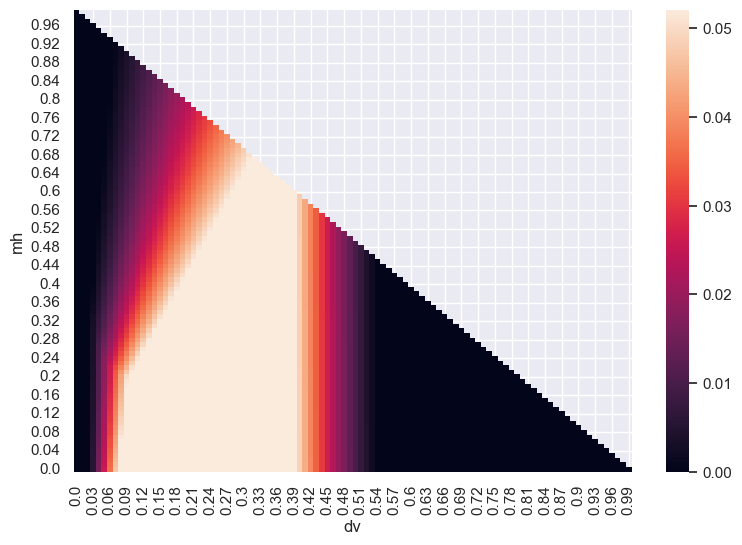

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Restructure dataframe for heatmap
growth_df_pivot = growth_df.pivot(index="mh", columns="dv", values="growth")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(growth_df_pivot, ax=ax)
ax.invert_yaxis()